Pleae enter either 'Static' for static emotion or 'live' for live emotion 
Static
number of instances:  35888
instance length:  2304
3
0.99997485
happy
https://open.spotify.com/playlist/2CB8XaNAfr8uLb75HiSZTY
  total tracks 10
   0                             ZAYN Dusk Till Dawn - Radio Edit
   1                    Justin Bieber Sorry
   2                       Luis Fonsi Despacito
   3                           ODESZA Higher Ground - Flight Facilities Remix
   4                      Mark Ronson Uptown Funk
   5                      OneRepublic Counting Stars
   6                    Justin Bieber Baby
   7                       Sonu Nigam Zoobi Doobi (From "3 Idiots")
   8                        Amir Khan Ajab Si
   9                       Katy Perry Firework


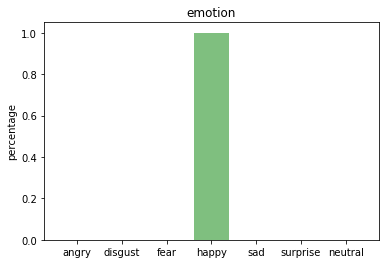

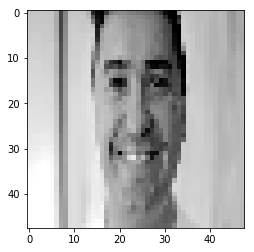

In [4]:
# function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    #Import required libraries
    import numpy as np
    import matplotlib.pyplot as plt
    
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5,color='g')

    for i, idx in enumerate(emotions):

        if(idx==max(emotions)):
            print (i)
            print (idx)
            x=objects[i]
            print (objects[i])
            suggest(x)

    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()
#----------------------------------------------------------------------------
#function to print the spotify tracks in python console
def show_tracks(tracks):
    for i, item in enumerate(tracks['items']):
        track = item['track']
        print("   %d %32.32s %s" % (i, track['artists'][0]['name'], track['name']))
#----------------------------------------------------------------------------
#function to suggest playlist in spotify from the detected emotion
def suggest(emo):

    import webbrowser
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    
    client_credentials_manager = SpotifyClientCredentials(client_id='c05f99ee0a2d4c059c835f8f4cbe2c73',
                                                          client_secret='596ed849c5a44891af5fdd1f74ba8365')
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    playlists = sp.user_playlists('li006zvua0ttqvdzzns2gwtu5')  # My User ID/Name

    for playlist in playlists['items']:
        if playlist['owner']['id'] == 'li006zvua0ttqvdzzns2gwtu5':
            if playlist['name'] == emo:
                print(playlist['external_urls']['spotify'])
                webbrowser.open(playlist['external_urls']['spotify'])
                print('  total tracks', playlist['tracks']['total'])
                results = sp.user_playlist('li006zvua0ttqvdzzns2gwtu5', playlist['id'], fields="tracks,next")
                tracks = results['tracks']
                show_tracks(tracks)
#----------------------------------------------------------------------------
#function to get emotion predictions from image
def static_img():
    
    import tensorflow as tf

    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
    from keras.layers import Dense, Activation, Dropout, Flatten

    from keras.preprocessing import image
    from keras.preprocessing.image import ImageDataGenerator

    import numpy as np
    import matplotlib.pyplot as plt

    # ------------------------------
    # cpu  configuration
    config = tf.ConfigProto(device_count={'GPU': 0, 'CPU': 56})  # max: 1 gpu, 56 cpu
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
    # ------------------------------
    # variables
    num_classes = 7  # angry, disgust, fear, happy, sad, surprise, neutral
    batch_size = 256
    epochs = 5
    # ------------------------------
    # read kaggle facial expression recognition challenge dataset (fer2013.csv)
    # https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

    with open("fer2013.csv") as f:
        content = f.readlines()

    lines = np.array(content)

    num_of_instances = lines.size
    print("number of instances: ", num_of_instances)
    print("instance length: ", len(lines[1].split(",")[1].split(" ")))

    # ------------------------------
    # initialize trainset and test set
    x_train, y_train, x_test, y_test = [], [], [], []

    # ------------------------------
    # transfer train and test set data
    for i in range(1, num_of_instances):
        try:
            emotion, img, usage = lines[i].split(",")
            val = img.split(" ")
            pixels = np.array(val, 'float32')
            emotion = keras.utils.to_categorical(emotion, num_classes)

            if 'Training' in usage:
                y_train.append(emotion)
                x_train.append(pixels)
            elif 'PublicTest' in usage:
                y_test.append(emotion)
                x_test.append(pixels)
        except:
            print("", end="")

    # ------------------------------
    # data transformation for train and test sets
    x_train = np.array(x_train, 'float32')
    y_train = np.array(y_train, 'float32')
    x_test = np.array(x_test, 'float32')
    y_test = np.array(y_test, 'float32')

    x_train /= 255  # normalize inputs between [0, 1]
    x_test /= 255

    x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
    x_test = x_test.astype('float32')

    # print(x_train.shape[0], 'train samples')
    # print(x_test.shape[0], 'test samples')
    # ------------------------------
    # construct CNN structure
    model = Sequential()

    # 1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

    # 2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    # 3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())

    # fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    model_config = model.to_json()
    open("model_structure.json", "w").write(model_config)
    # ------------------------------
    # batch process
    gen = ImageDataGenerator()
    train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

    # ------------------------------

    model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                  )

    # ------------------------------

    # fit = True
    fit = False

    if fit == True:
        # model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
        model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)
        model.save("modelcross.hdf5")
        # model.load_weights('modelcross.hdf5')
    # model.save_weights('model_weights.h5')
    # train for randomly selected one
    else:
        model.load_weights('facial_expression_model_weights.h5')  # load weights
    # ------------------------------

    #overall evaluation
    # score = model.evaluate(x_test, y_test)
    # print('Test loss:', score[0])
    # print('Test accuracy:', 100*score[1])

    monitor_testset_results = False

    if monitor_testset_results == True:
        # make predictions for test set
        predictions = model.predict(x_test)

        index = 0
        for i in predictions:
            if index < 30 and index >= 20:
                # print(i) #predicted scores
                # print(y_test[index]) #actual scores

                testing_img = np.array(x_test[index], 'float32')
                testing_img = testing_img.reshape([48, 48]);

                plt.gray()
                plt.imshow(testing_img)
                plt.show()

                print(i)

                emotion_analysis(i)
                print("----------------------------------------------")
            index = index + 1

    # ------------------------------
    # make prediction for custom image out of test set
    img = image.load_img("images/happy_man.jpg", grayscale=True, target_size=(48, 48))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x /= 255

    custom = model.predict(x)
    emotion_analysis(custom[0])

    x = np.array(x, 'float32')
    x = x.reshape([48, 48]);

    plt.gray()
    plt.imshow(x)
    plt.show()
#------------------------------------------------------------------
#function to Capture image from live webcam feed
def webcam():

    import numpy as np
    import cv2
    import spotipy
    import webbrowser
    import time
    import matplotlib.pyplot as plt
    from keras.preprocessing import image
    
    # -----------------------------
    # opencv initialization

    face_cascade = cv2.CascadeClassifier(
        'haarcascade_frontalface_default.xml')

    cap = cv2.VideoCapture(0)
    img_counter = 0

    # -----------------------------
    # face expression recognizer initialization
    from keras.models import model_from_json

    model = model_from_json(open("facial_expression_model_structure.json", "r").read())
    model.load_weights('facial_expression_model_weights.h5')  # load weights

    # -----------------------------

    mins = 0

    emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

    while (True):
        ret, img = cap.read()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # print(faces) #locations of detected faces

        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # draw rectangle to main image

            detected_face = img[int(y):int(y + h), int(x):int(x + w)]  # crop detected face
            detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY)  # transform to gray scale
            detected_face = cv2.resize(detected_face, (48, 48))  # resize to 48x48

            img_pixels = image.img_to_array(detected_face)
            img_pixels = np.expand_dims(img_pixels, axis=0)

            img_pixels /= 255  # pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]

            predictions = model.predict(img_pixels)  # store probabilities of 7 expressions

            # find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
            max_index = np.argmax(predictions[0])

            emotion = emotions[max_index]

            print(emotion)

            # write emotion text above rectangle
            cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)

        """ while mins != 2:
                for playlist in playlists['items']:
                    if playlist['owner']['id'] == 'li006zvua0ttqvdzzns2gwtu5':
                        if playlist['name'] == emotion:
                            print(playlist['external_urls']['spotify'])
                            webbrowser.open(playlist['external_urls']['spotify'])
                            print('  total tracks', playlist['tracks']['total'])
                            results = sp.user_playlist('li006zvua0ttqvdzzns2gwtu5', playlist['id'], fields="tracks,next")
                            tracks = results['tracks']
                            show_tracks(tracks)
                        break
                    break
                time.sleep(60)
                mins += 1"""

        # process on detected face end
        # -------------------------

        cv2.imshow('img', img)

        if not ret:
            break
        k = cv2.waitKey(1)

        if k % 256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k % 256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, img)
            print("{} written!".format(img_name))
            
            img_counter += 1
            img = image.load_img(img_name, grayscale=True, target_size=(48, 48))

            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)

            x /= 255

            #custom = model.predict(x)
            #emotion_analysis(custom[0])

            x = np.array(x, 'float32')
            x = x.reshape([48, 48]);

            suggest(emotion)
            plt.gray()
            plt.imshow(x)
            plt.show()

            objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
            y_pos = np.arange(len(objects))
            plt.bar(y_pos, predictions[0], align='center', alpha=0.5,color='r')
            plt.xticks(y_pos, objects)
            plt.ylabel('percentage')
            plt.title('emotion')
            plt.show()

        if cv2.waitKey(1) & 0xFF == ord('q'):  # press q to quit
            break

    # kill opencv
    cap.release()
    cv2.destroyAllWindows()
#----------------------------------------------------------------------------
#Getting input from the user
print("Pleae enter either 'Static' for static emotion or 'live' for live emotion ")
choice=input()
if(choice=='Static'):
    static_img()
else:
    webcam()